In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision
import torchvision.models
from torchmetrics import TotalVariation

import copy
from PIL import Image
import matplotlib.pyplot as plt

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.device(device)

device(type='cpu')

In [31]:
device = torch.device("cpu")

## Load Image to perform style transfer with the method proposed by Gatys et al.

In [63]:
# simple than using the actual dataloading (as the functionality is the same without any wrappers)
transform = transforms.Compose(
    [transforms.Resize(256), transforms.CenterCrop((256, 256)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)


def load_img(name):
    img = Image.open(name)
    img = torch.reshape(transform(img), (1, 3, 256, 256))
    return img.to(device, torch.float)


style_img = load_img("./style_images/style5.jpg")
content_img = load_img("./test_images/test1.jpg")

## Display

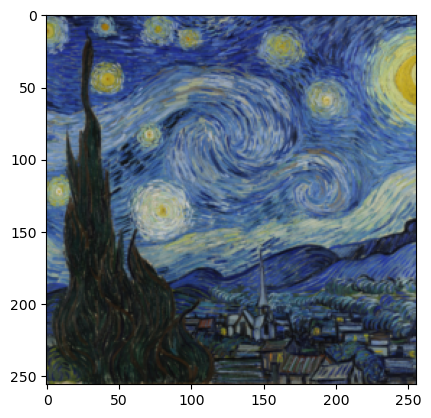

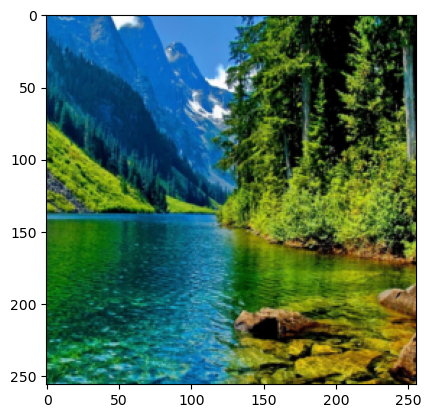

In [64]:
def show_img(tensor):
    plt.figure()
    img = tensor.cpu().clone()  # need to clone the tensor to not do changes on it
    image = torch.reshape(img, (3, 256, 256))
    # unnormalize:
    image = image * torch.tensor([0.229, 0.224, 0.225]).unsqueeze(-1).unsqueeze(-1)
    image = image + torch.tensor([0.485, 0.456, 0.406]).unsqueeze(-1).unsqueeze(-1)
    image = torch.clamp(image, 0.0, 1.0)
    # image = image
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.show()


show_img(style_img)
show_img(content_img)

# Loss

In [65]:
from src.loss import LossCalculator

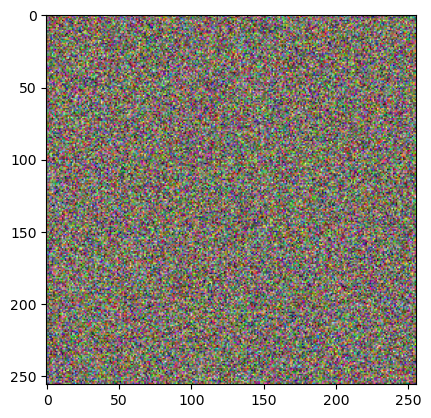

In [66]:
# input_img = content_img.clone() # clone the content image as the start image to optimize
input_img = torch.randn(1, 3, 256, 256).to(device)
input_img.requires_grad_(True)

show_img(input_img)

In [67]:
from timm.models.vision_transformer import Attention

# class Attention(nn.Module):
#     fused_attn: Final[bool]

#     def __init__(
#             self,
#             dim: int,
#             num_heads: int = 8,
#             qkv_bias: bool = False,
#             qk_norm: bool = False,
#             proj_bias: bool = True,
#             attn_drop: float = 0.,
#             proj_drop: float = 0.,
#             norm_layer: Type[nn.Module] = nn.LayerNorm,
#     ) -> None:
#         super().__init__()
#         assert dim % num_heads == 0, 'dim should be divisible by num_heads'
#         self.num_heads = num_heads
#         self.head_dim = dim // num_heads
#         self.scale = self.head_dim ** -0.5
#         self.fused_attn = use_fused_attn()

#         self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
#         self.q_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
#         self.k_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
#         self.attn_drop = nn.Dropout(attn_drop)
#         self.proj = nn.Linear(dim, dim, bias=proj_bias)
#         self.proj_drop = nn.Dropout(proj_drop)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
        # B, N, C = x.shape
        # qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        # q, k, v = qkv.unbind(0)
        # q, k = self.q_norm(q), self.k_norm(k)

#         if self.fused_attn:
#             x = F.scaled_dot_product_attention(
#                 q, k, v,
#                 dropout_p=self.attn_drop.p if self.training else 0.,
#             )
#         else:
        #     q = q * self.scale
        #     attn = q @ k.transpose(-2, -1)
        #     attn = attn.softmax(dim=-1)
        #     attn = self.attn_drop(attn)
        #     x = attn @ v

        # x = x.transpose(1, 2).reshape(B, N, C)
        # x = self.proj(x)
        # x = self.proj_drop(x)
        # return x


class AttentionWithScores(nn.Module):
    def __init__(self, backbone_attention: Attention):
        super().__init__()
        self.backbone_att = backbone_attention
        self.attention_scores_prev = None
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.backbone_att.qkv(x).reshape(B, N, 3, self.backbone_att.num_heads, self.backbone_att.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        q, k = self.backbone_att.q_norm(q), self.backbone_att.k_norm(k)
        
        q = q * self.backbone_att.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1) # attention scores
        self.attention_scores_prev = attn.clone() # has shape B, num_heads, seq_len, seq_len (257)
        attn = self.backbone_att.attn_drop(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.backbone_att.proj(x)
        x = self.backbone_att.proj_drop(x)
        return x

In [68]:
import timm

class MyLossTransformer(nn.Module):
    def __init__(self, content_layers, style_layers, ACCELERATOR, **kwargs):
        super().__init__()
        self.kwargs = kwargs
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.ACCELERATOR = ACCELERATOR
        self.transformer_net = timm.create_model(
            'vit_large_patch14_dinov2.lvd142m',
            pretrained=True,
            num_classes=0,  # remove classifier nn.Linear
            img_size=256,
        )
        for param in self.transformer_net.parameters(): # freeze the model
            param.requires_grad = False
        
        for block in self.transformer_net.blocks:
            block.attn = AttentionWithScores(block.attn)
        
        
        # self.normalization = Normalization(vgg_mean, vgg_std).to(ACCELERATOR)
        
    
    def forward(self, x):
        x = x.to(self.ACCELERATOR)
        embedding = self.transformer_net(x)
        
        # extract style stuff
        attn_score_list = []
        for block in self.transformer_net.blocks:
            attn_score_list.append(block.attn.attention_scores_prev)
            
        
        out_styles =[alist for i, alist in enumerate(attn_score_list) if i in self.style_layers]
        return [embedding] , out_styles

In [69]:
net = MyLossTransformer([], [1], "cpu")
x = torch.randn(2, 3, 256, 256)
x2 = x.clone()
embedding_1, style_embedding = net(x)
embedding_1 = embedding_1[0]
style_embedding = style_embedding[0]

net2 = timm.create_model(
    'vit_large_patch14_dinov2.lvd142m',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
    img_size=256,
)

for param in net2.parameters(): # freeze the model
    param.requires_grad = False
embedding_2 = net2(x2)

print(embedding_1 - embedding_2)
print(style_embedding.shape)

tensor([[ 7.1526e-06,  4.0233e-06, -4.5896e-06,  ...,  2.8610e-06,
          2.3842e-07, -3.6955e-06],
        [-2.8610e-06,  1.4603e-06, -6.1989e-06,  ..., -9.5367e-07,
         -4.1723e-06, -1.9073e-06]])
torch.Size([2, 16, 325, 325])


In [70]:
from src.loss import LossCalculator
style_layers = [5, 10, 15]
content_layers = [-1]
lc = LossCalculator(content_layers, style_layers, loss_net=MyLossTransformer(content_layers, style_layers, "cpu"), )

/Users/robert/miniconda3/envs/neural_bandits/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `TotalVariation` from `torchmetrics` was deprecated and will be removed in 2.0. Import `TotalVariation` from `torchmetrics.image` instead.
  _future_warning(


Loss: 281.74: 100%|██████████| 300/300 [13:02<00:00,  2.61s/it]


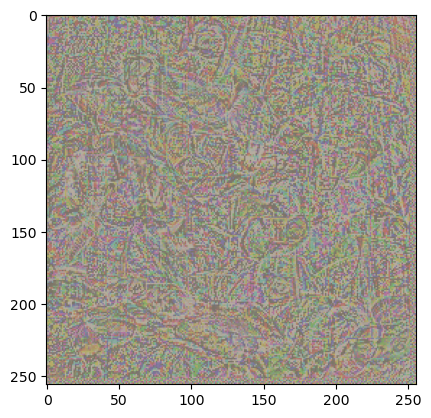

In [81]:
import tqdm

# a simple demo of style transfer with the method proposed by Gatys et al.
# demonstrates why the method is not suitable for real-time style transfer
def style_transfer(
    content_img,
    style_img,
    input_img,
    iterations=300,
    style_factor=1,
    content_factor=1,
    grad_norm=True,
):
    optimizer = optim.LBFGS([input_img], lr=1e-2)
    bar = tqdm.tqdm(range(iterations))
    for steps in bar:
        optimizer.zero_grad()
        loss = lc.calculate_loss(
            content_factor, style_factor, 0, input_img, style_img, content_img
        )
        loss.backward()
        
        if grad_norm:
            torch.nn.utils.clip_grad_norm_([input_img], 1.0, norm_type=2.0, error_if_nonfinite=False, foreach=None)
        
        bar.set_description("Loss: {:.2f}".format(loss.item()))

        # if steps % 10 == 0:
        #     print("Run: {} \t Loss : {:2f}".format(steps, loss.item()))

        steps += 1
        optimizer.step(lambda: loss)

        with torch.no_grad():
            input_img.clamp_(0, 1)  # always keep the input image in the range [0,1]

    return input_img


output = style_transfer(content_img, style_img, input_img)

show_img(output)

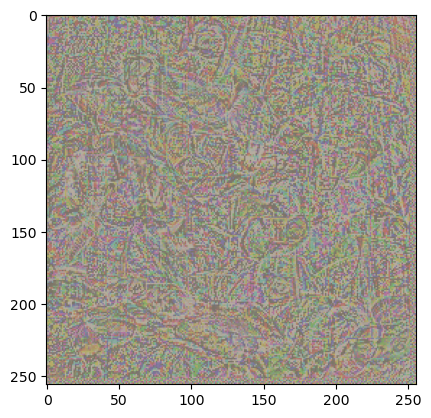

In [82]:
show_img(input_img.detach())

# Now the style transfer CNN approach

In [25]:
from src.architecture import ImageTransformNet

# DEMO that takes a webcam stream and performs style transfer in real time.

In [ ]:
# source: https://stackoverflow.com/questions/2601194/displaying-a-webcam-feed-using-opencv-and-python/11449901#11449901
import cv2
import torch
import PIL.Image as Image
import torchvision.transforms as transforms
from matplotlib.animation import FuncAnimation
import numpy as np

import time

device = torch.device("cpu")

import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

pretrained_filename = "./checkpoints/<class 'src.models.johnson_model.JohnsonsImageTransformNet'>--2023-08-03_16-22-39vanGogh--up--in--vgg16--1-25-1e-5--allreflect--longer--end.pth"
pretrained_filename = "./checkpoints/<class 'src.models.johnson_model.JohnsonsImageTransformNet'>--2023-08-03_21-08-55vanGogh--up--in--vgg16--1-250-1e-5--allreflect--end--ownloss.pth"

model = ImageTransformNet()
model.load_state_dict(torch.load(pretrained_filename, map_location=device))
model = model.to(device)
# take frame from webcam
vc = cv2.VideoCapture(0)
frame_counter = 0
start_time = time.time()

if vc.isOpened():  # try to get the first frame
    rval, frame = vc.read()
else:
    print("Webcam not found")

try:
    while time.time() - start_time < 100:
        clear_output(wait=True)

        frame_counter += 1
        rval, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame)
        model_input = transform(frame_pil)
        model_input = model_input.unsqueeze(0).to(device)

        frame_out = model(model_input).squeeze(0)
        frame_out = torch.clamp(frame_out, 0, 1)
        frame_out = frame_out.permute(1, 2, 0).cpu().detach().numpy()

        plt.imshow(frame_out)
        plt.axis("off")
        plt.show()

except Exception as e:
    print(e)

vc.release()

print("FPS: {:2f}".format(frame_counter / (time.time() - start_time)))

In [12]:
# if the above cell is stopped, run this cell to release the camera
vc.release()